In [1]:
import requests
import cv2
from matplotlib import pyplot as plt 
import numpy as np


## Gradient distribution

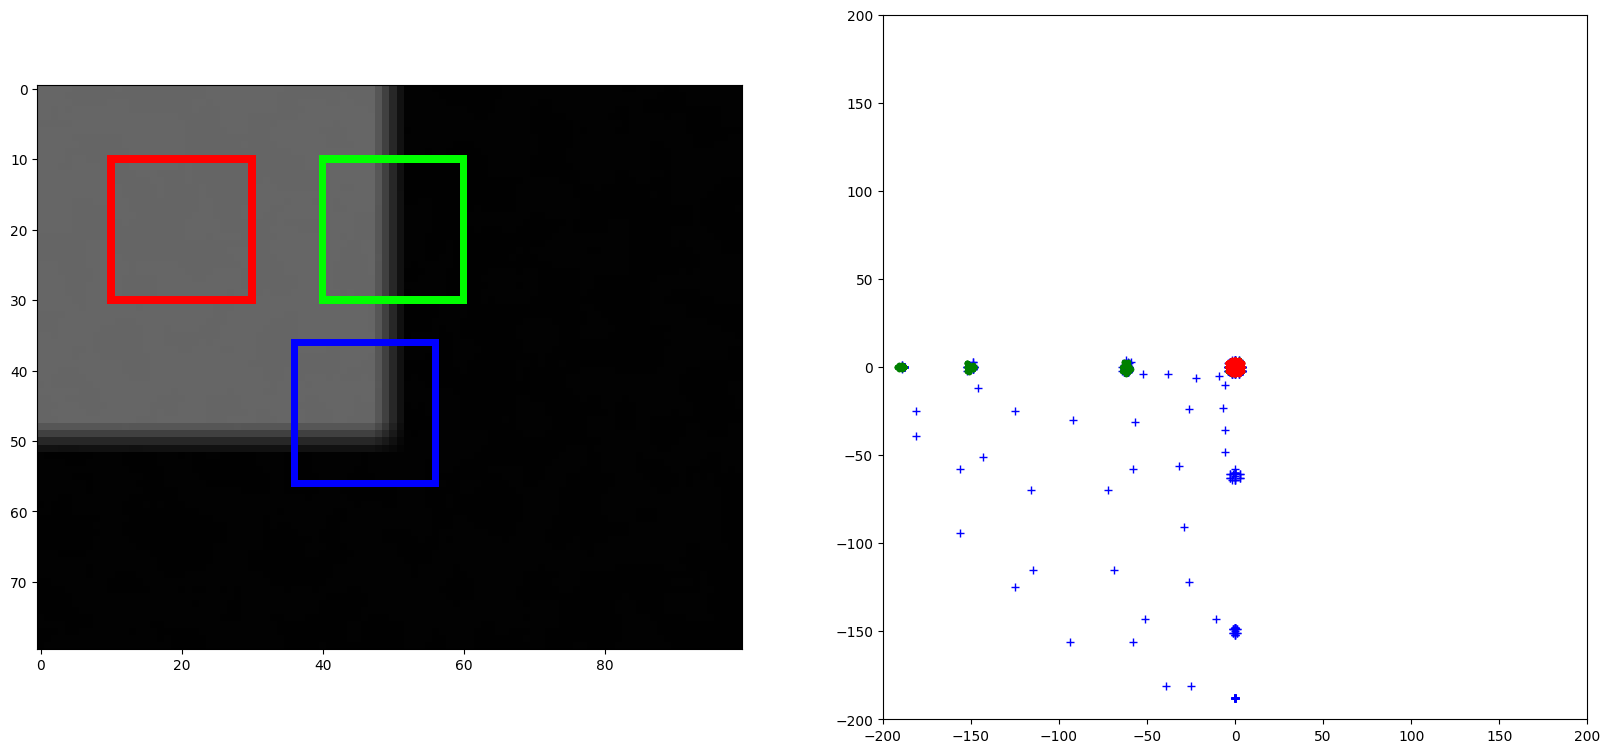

In [10]:
# Create a black image (all zeros) with dimensions 400x400 and 3 channels (for color)
image = np.random.randint(0,4,(80,100),dtype=np.uint8)
image[:50, :50] += 100
image = cv2.GaussianBlur(image, (5,5), 2)

l = 20
box1 = (10,10)
box2 = (10,40)
box3 = (36,36)

# Apply sobel edge detection
sobelx = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3) 
sobely = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3) 
drv = np.dstack((sobelx, sobely))

drv1 = drv[box1[0]:box1[0]+l, box1[1]: box1[1]+l,:]
drv2 = drv[box2[0]:box2[0]+l, box2[1]: box2[1]+l,:]
drv3 = drv[box3[0]:box3[0]+l, box3[1]: box3[1]+l,:]

mag1 = np.linalg.norm(drv1, axis=2)
mag2 = np.linalg.norm(drv2, axis=2)
mag3 = np.linalg.norm(drv3, axis=2)

# Display the image and derivatives
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
image_ = image.copy()
image_ = np.repeat(image_[:,:,np.newaxis],3, axis=2)
cv2.rectangle(image_, (box1[1], box1[0]), (box1[1]+l, box1[0]+l), (255, 0, 0), 1)
cv2.rectangle(image_, (box2[1], box2[0]), (box2[1]+l, box2[0]+l), (0, 255, 0), 1)
cv2.rectangle(image_, (box3[1], box3[0]), (box3[1]+l, box3[0]+l), (0, 0, 255), 1)
plt.imshow(image_)

#plt.quiver(np.linspace(box1[1], box1[1]+l, int(l/2)), 
#           np.linspace(box1[0], box1[0]+l, int(l/2)),
#           drv1[::2,::2,0], drv1[::2,::2,1], color='m', scale = 4000
#           )
#plt.quiver(np.linspace(box2[1], box2[1]+l, int(l/2)), 
#           np.linspace(box2[0], box2[0]+l, int(l/2)),
#           drv2[::2,::2,0], drv2[::2,::2,1], color='m', scale = 4000
#           )
#plt.quiver(np.linspace(box3[1], box3[1]+l, int(l/2)), 
#           np.linspace(box3[0], box3[0]+l, int(l/2)),
#           drv3[::2,::2,0], drv3[::2,::2,1], color='m', scale = 4000,
#           )

axs = plt.subplot(1,2,2)
plt.plot(drv3.reshape(-1,2)[:,0], drv3.reshape(-1,2)[:,1],'b+')
plt.xlim(-200,200)
plt.ylim(-200,200)

plt.plot(drv2.reshape(-1,2)[:,0], drv2.reshape(-1,2)[:,1],'g.')
plt.xlim(-200,200)
plt.ylim(-200,200)

plt.plot(drv1.reshape(-1,2)[:,0], drv1.reshape(-1,2)[:,1],'r.')
plt.xlim(-200,200)
plt.ylim(-200,200)

axs = plt.gca()
axs.set_aspect('equal')

## Harris Corner detection

(Text(0.5, 1.0, 'Image'), ([], []), ([], []))

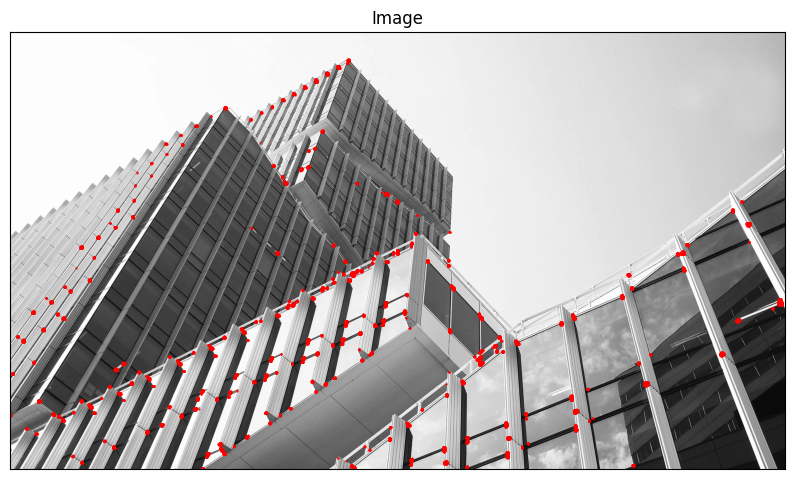

In [35]:
# Read the image
image = cv2.imread('./data/images/building.jpeg', cv2.IMREAD_GRAYSCALE)

# Apply the Harris Corner Detector
harris_response = cv2.cornerHarris(image, blockSize=9, ksize=5, k=0.04)

# Threshold the response to identify corners
threshold = 0.05 * harris_response.max()
corner_mask = (harris_response > threshold).astype(np.uint8) * 255

# Get the x, y coordinates of the corners
#coordinates = np.column_stack(np.where(corner_mask > 0))
coordinates = np.where(corner_mask > 0)

# Display the original image and detected corners
plt.figure(figsize=(10, 10))

plt.subplot(111), plt.imshow(image, cmap='gray')
#plt.scatter(coordinates[:, 1], coordinates[:, 0], color='red', marker='.', s=1)
plt.scatter(coordinates[1], coordinates[0], color='red', marker='.', s=1)
plt.title('Image'), plt.xticks([]), plt.yticks([])

